# **Author: Joshua Johnson**


The Sparks Foundation: Data Science And Business Analytics Internship

# **TASK 7: Stock Market Prediction using Numerical and Textual Analysis**

Objective:

●Create a hybrid model for stock price/performance 
prediction using numerical analysis of historical stock prices, and 
sentimental analysis of news headlines 

● Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

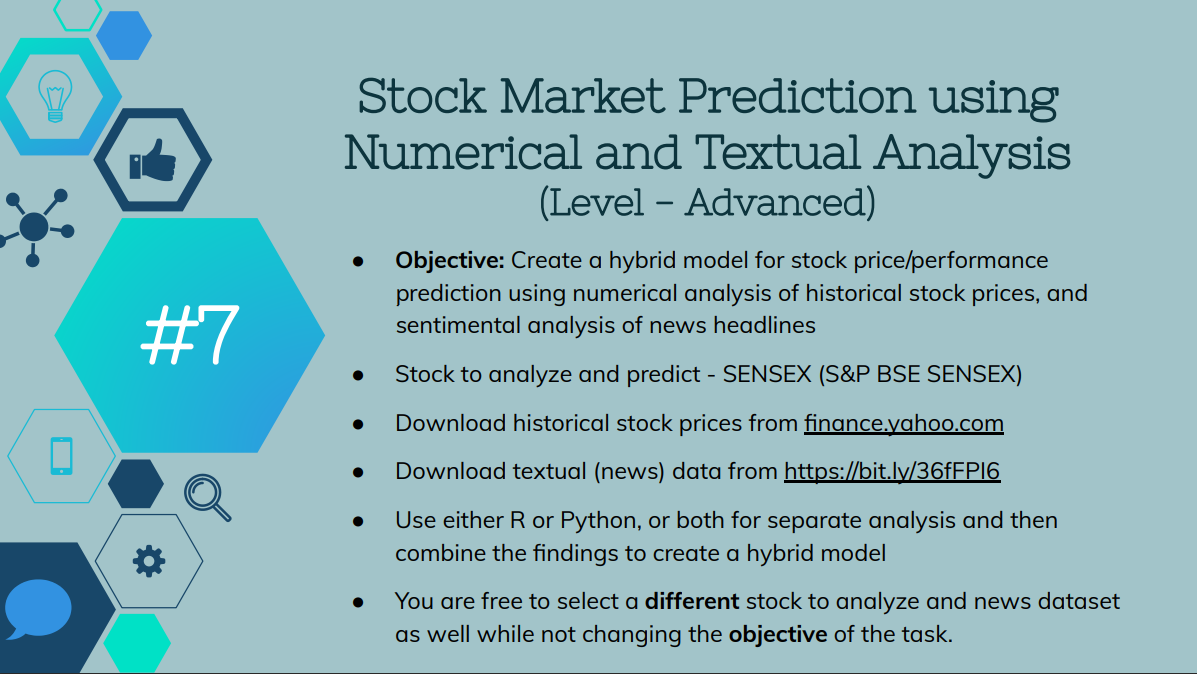

In [ ]:
#importing libraries 
import warnings
warnings.filterwarnings('ignore')
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
stock_price = pd.read_csv('/content/AAPL.csv')
stock_headlines = pd.read_csv('/content/india-news-headlines.csv')

In [ ]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-02-17,131.250000,132.220001,129.470001,130.839996,129.283783,97918500
1,2021-02-18,129.199997,130.000000,127.410004,129.710007,128.167206,96856700
2,2021-02-19,130.240005,130.710007,128.800003,129.869995,128.325317,87668800
3,2021-02-22,128.009995,129.720001,125.599998,126.000000,124.501350,103916400
4,2021-02-23,123.760002,126.709999,118.389999,125.860001,124.363014,158273000


In [ ]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [ ]:
# stock price

stock_price = stock_price.drop_duplicates()
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])
stock_price.set_index('Date', inplace= True)
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price    

,Close,Open,High,Low,Volume
Date,,,,,
2021-02-17,130.839996,131.250000,132.220001,129.470001,97918500
2021-02-18,129.710007,129.199997,130.000000,127.410004,96856700
2021-02-19,129.869995,130.240005,130.710007,128.800003,87668800
2021-02-22,126.000000,128.009995,129.720001,125.599998,103916400
2021-02-23,125.860001,123.760002,126.709999,118.389999,158273000
...,...,...,...,...,...
2023-02-10,151.009995,149.460007,151.339996,149.220001,57409100
2023-02-13,153.850006,150.949997,154.259995,150.919998,62199000
2023-02-14,153.199997,152.119995,153.770004,150.860001,61707600


In [ ]:
# stock headlines

stock_headlines = stock_headlines.drop_duplicates()
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()
stock_headlines.set_index('publish_date', inplace= True)
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


In [ ]:
stock_data = pd.concat([stock_price, stock_headlines], axis=1)
stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2021-02-17,130.839996,131.250000,132.220001,129.470001,97918500.0,Gorakhpur's terracotta isfamous in world now: ...
2021-02-18,129.710007,129.199997,130.000000,127.410004,96856700.0,"Solve issues of cane farmers on priority,Pogar..."
2021-02-19,129.869995,130.240005,130.710007,128.800003,87668800.0,Will Speedy be able to spend time with his GF ...
2021-02-22,126.000000,128.009995,129.720001,125.599998,103916400.0,Tourism dept's benches at Anjuna hill vandalis...
2021-02-23,125.860001,123.760002,126.709999,118.389999,158273000.0,Crooks selling firearms online usingslain gang...
...,...,...,...,...,...,...
2022-03-25,174.720001,173.880005,175.279999,172.750000,80546200.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,175.600006,172.169998,175.729996,172.000000,90371900.0,As fashion becomes democratic; demand for styl...
2022-03-29,178.960007,176.690002,179.009995,176.339996,100589400.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,177.770004,178.550003,179.610001,176.699997,92633200.0,"I will not give in to trends: Dossmode,The tim..."


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sid = SentimentIntensityAnalyzer()

In [ ]:
# calculating sentiment scores
stock_data['compound'] = ''
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
stock_data.drop(['headline_text'], inplace=True, axis=1)
stock_data = stock_data[['Close', 'compound', 'Open', 'High', 'Low', 'Volume']]

# displaying the final stock_data
stock_data.head()

,Close,compound,Open,High,Low,Volume
2021-02-17,130.839996,-0.9996,131.250000,132.220001,129.470001,97918500.0
2021-02-18,129.710007,-0.9993,129.199997,130.000000,127.410004,96856700.0
2021-02-19,129.869995,-0.9998,130.240005,130.710007,128.800003,87668800.0
2021-02-22,126.000000,-0.9999,128.009995,129.720001,125.599998,103916400.0
2021-02-23,125.860001,-0.9998,123.760002,126.709999,118.389999,158273000.0


In [ ]:
stock_data =stock_data.reset_index()
stock_data

,index,Close,compound,Open,High,Low,Volume
0,2021-02-17,130.839996,-0.9996,131.250000,132.220001,129.470001,97918500.0
1,2021-02-18,129.710007,-0.9993,129.199997,130.000000,127.410004,96856700.0
2,2021-02-19,129.869995,-0.9998,130.240005,130.710007,128.800003,87668800.0
3,2021-02-22,126.000000,-0.9999,128.009995,129.720001,125.599998,103916400.0
4,2021-02-23,125.860001,-0.9998,123.760002,126.709999,118.389999,158273000.0
...,...,...,...,...,...,...,...
279,2022-03-25,174.720001,-0.9999,173.880005,175.279999,172.750000,80546200.0
280,2022-03-28,175.600006,-0.9999,172.169998,175.729996,172.000000,90371900.0
281,2022-03-29,178.960007,-0.9998,176.690002,179.009995,176.339996,100589400.0
282,2022-03-30,177.770004,-0.9999,178.550003,179.610001,176.699997,92633200.0


In [ ]:
stock_data.describe()

,Close,compound,Open,High,Low,Volume
count,284.000000,284.000000,284.000000,284.000000,284.000000,2.840000e+02
mean,147.670916,-0.971390,147.507641,149.144859,146.015035,9.022283e+07
std,17.623612,0.235479,17.529904,17.869490,17.288654,2.737271e+07
min,116.360001,-0.999900,119.029999,120.400002,116.209999,4.100000e+07
25%,131.902500,-0.999900,131.647499,132.992496,130.532505,7.110102e+07
50%,147.210000,-0.999800,147.355003,148.785004,146.159996,8.658110e+07
75%,162.057502,-0.999700,161.872494,164.599999,159.659999,1.045706e+08
max,182.009995,0.999800,182.630005,182.940002,179.119995,1.954327e+08


Text(0, 0.5, 'Closed Price')

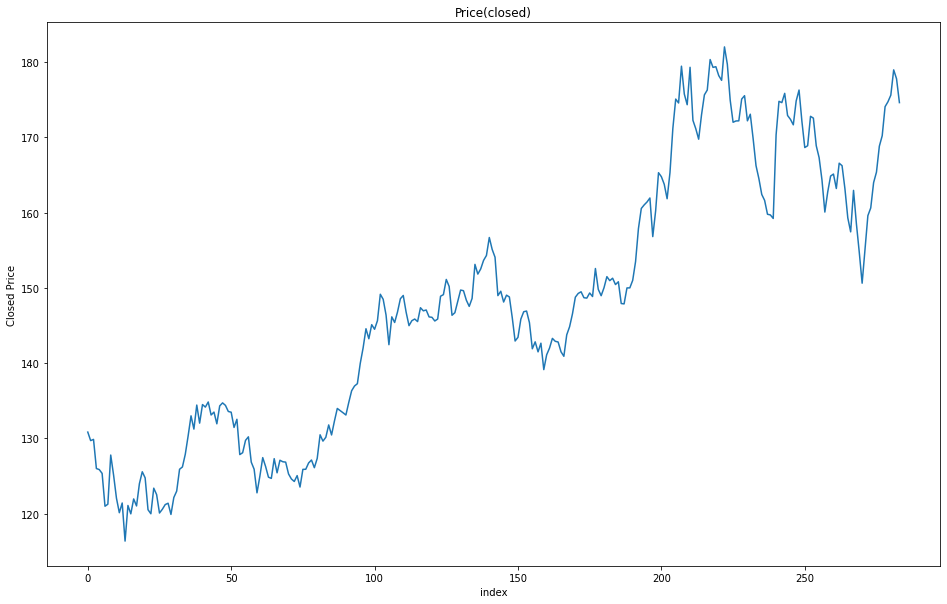

In [ ]:
# plotting the stock data

plt.figure(figsize=(16,10))
stock_data['Close'].plot()
plt.title("Price(closed)")
plt.xlabel('index')
plt.ylabel('Closed Price')
     

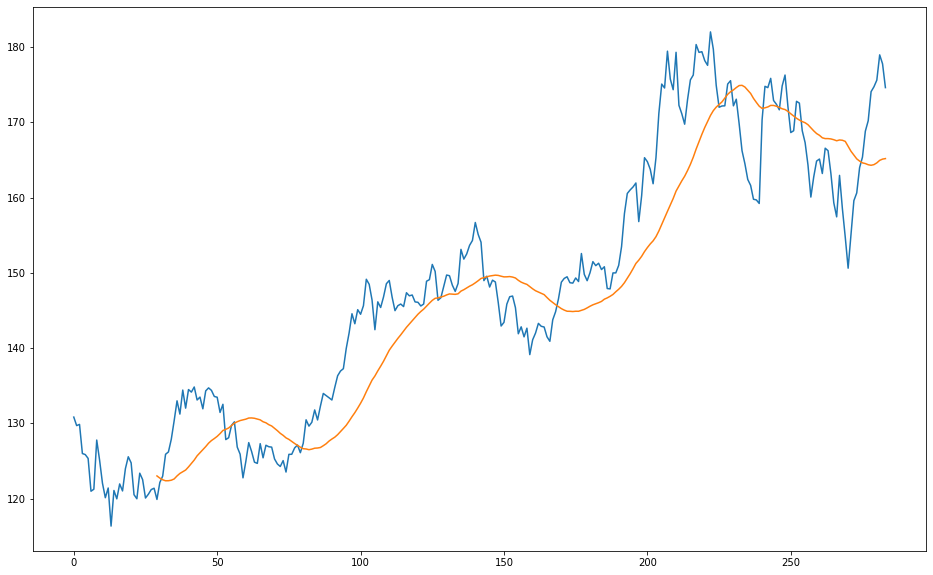

In [ ]:
# visualizing the close price and a 30-day rolling mean window of close price

plt.figure(figsize=(16,10))
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [ ]:
stock_data

,index,Close,compound,Open,High,Low,Volume
0,2021-02-17,130.839996,-0.9996,131.250000,132.220001,129.470001,97918500.0
1,2021-02-18,129.710007,-0.9993,129.199997,130.000000,127.410004,96856700.0
2,2021-02-19,129.869995,-0.9998,130.240005,130.710007,128.800003,87668800.0
3,2021-02-22,126.000000,-0.9999,128.009995,129.720001,125.599998,103916400.0
4,2021-02-23,125.860001,-0.9998,123.760002,126.709999,118.389999,158273000.0
...,...,...,...,...,...,...,...
279,2022-03-25,174.720001,-0.9999,173.880005,175.279999,172.750000,80546200.0
280,2022-03-28,175.600006,-0.9999,172.169998,175.729996,172.000000,90371900.0
281,2022-03-29,178.960007,-0.9998,176.690002,179.009995,176.339996,100589400.0
282,2022-03-30,177.770004,-0.9999,178.550003,179.610001,176.699997,92633200.0


In [ ]:
# preparing the data

percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

In [ ]:
# predicting 
steps_to_predict = 1
close_price = stock_data.iloc[start:total_data,1]
compound = stock_data.iloc[start:total_data,2] #compound
open_price = stock_data.iloc[start:total_data,3] 
high = stock_data.iloc[start:total_data,4] #high
low = stock_data.iloc[start:total_data,5] #low
volume = stock_data.iloc[start:total_data,6] #volume


close_price

1      129.710007
2      129.869995
3      126.000000
4      125.860001
5      125.349998
          ...    
279    174.720001
280    175.600006
281    178.960007
282    177.770004
283    174.610001
Name: Close, Length: 283, dtype: float64

In [ ]:
# shifting close price

close_price_shifted = close_price.shift(-1) 
compound_shifted = compound.shift(-1) 
data = pd.concat([close_price, close_price_shifted,compound, compound_shifted,volume,open_price, high, low], axis=1)
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']
data = data.dropna()   
data.head(10)
     

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
1,129.710007,129.869995,-0.9993,-0.9998,96856700.0,129.199997,130.000000,127.410004
2,129.869995,126.000000,-0.9998,-0.9999,87668800.0,130.240005,130.710007,128.800003
3,126.000000,125.860001,-0.9999,-0.9998,103916400.0,128.009995,129.720001,125.599998
4,125.860001,125.349998,-0.9998,-0.9999,158273000.0,123.760002,126.709999,118.389999
5,125.349998,120.989998,-0.9999,-0.9992,111039900.0,124.940002,125.559998,122.230003
6,120.989998,121.260002,-0.9992,-0.9997,148199500.0,124.680000,126.459999,120.540001
7,121.260002,127.790001,-0.9997,-0.9993,164560400.0,122.589996,124.849998,121.199997
8,127.790001,125.120003,-0.9993,-0.9999,116307900.0,123.750000,127.930000,122.790001
9,125.120003,122.059998,-0.9999,-0.9998,102260900.0,128.410004,128.720001,125.010002
10,122.059998,120.129997,-0.9998,-0.9998,112966300.0,124.809998,125.709999,121.839996


In [ ]:
y = data['close_price_shifted']
y

1      129.869995
2      126.000000
3      125.860001
4      125.349998
5      120.989998
          ...    
278    174.720001
279    175.600006
280    178.960007
281    177.770004
282    174.610001
Name: close_price_shifted, Length: 282, dtype: float64

In [ ]:
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
1,129.710007,-0.9993,-0.9998,96856700.0,129.199997,130.000000,127.410004
2,129.869995,-0.9998,-0.9999,87668800.0,130.240005,130.710007,128.800003
3,126.000000,-0.9999,-0.9998,103916400.0,128.009995,129.720001,125.599998
4,125.860001,-0.9998,-0.9999,158273000.0,123.760002,126.709999,118.389999
5,125.349998,-0.9999,-0.9992,111039900.0,124.940002,125.559998,122.230003
...,...,...,...,...,...,...,...
278,174.070007,-0.9999,-0.9999,90131400.0,171.059998,174.139999,170.210007
279,174.720001,-0.9999,-0.9999,80546200.0,173.880005,175.279999,172.750000
280,175.600006,-0.9999,-0.9998,90371900.0,172.169998,175.729996,172.000000
281,178.960007,-0.9998,-0.9999,100589400.0,176.690002,179.009995,176.339996


In [ ]:
# scaling the feature dataset

scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)
x, y

(array([[-0.59329757, -0.99939991, -0.99989998, ..., -0.68018877,
         -0.69299655, -0.6439356 ],
        [-0.5884236 , -0.99989998, -1.        , ..., -0.64748412,
         -0.67029085, -0.59974552],
        [-0.7063214 , -1.        , -0.99989998, ..., -0.71761022,
         -0.70195078, -0.70147832],
        ...,
        [ 0.80472233, -1.        , -0.99989998, ...,  0.67106899,
          0.76942737,  0.77364503],
        [ 0.90708337, -0.99989998, -1.        , ...,  0.81320747,
          0.87432021,  0.9116198 ],
        [ 0.87083042, -1.        , -1.        , ...,  0.87169806,
          0.89350812,  0.92306475]]), array([[-0.5884236 ],
        [-0.7063214 ],
        [-0.71058642],
        [-0.72612345],
        [-0.85894905],
        [-0.85072349],
        [-0.65178976],
        [-0.73313015],
        [-0.82635194],
        [-0.88514863],
        [-0.84584928],
        [-1.        ],
        [-0.85590265],
        [-0.88971813],
        [-0.82939837],
        [-0.85773044],
      

In [ ]:
# splitting into train and test
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

In [ ]:
# reshaping

X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [ ]:
np.random.seed(2016)
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
# fitting the model using 50 epochs

model.compile(loss='mse' , optimizer='adam')
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
19/19 [==============================] - 9s 140ms/step - loss: 0.1182 - val_loss: 0.4525
Epoch 2/50
19/19 [==============================] - 1s 36ms/step - loss: 0.0770 - val_loss: 0.3632
Epoch 3/50
19/19 [==============================] - 1s 42ms/step - loss: 0.0627 - val_loss: 0.2513
Epoch 4/50
19/19 [==============================] - 1s 38ms/step - loss: 0.0486 - val_loss: 0.1477
Epoch 5/50
19/19 [==============================] - 1s 42ms/step - loss: 0.0419 - val_loss: 0.1002
Epoch 6/50
19/19 [==============================] - 1s 32ms/step - loss: 0.0448 - val_loss: 0.1458
Epoch 7/50
19/19 [==============================] - 1s 29ms/step - loss: 0.0402 - val_loss: 0.1301
Epoch 8/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0351 - val_loss: 0.1326
Epoch 9/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0408 - val_loss: 0.1830
Epoch 10/50
19/19 [==============================] - 0s 25ms/step - loss: 0.0389 - val_loss: 0.1624
Epoch 11

In [ ]:
# predictions
predictions = model.predict(X_test) 
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))
print('Predictions:')
predictions[0:5]

2/2 [==============================] - 2s 12ms/step
Predictions:


array([[165.33093],
       [166.1353 ],
       [165.35478],
       [164.8336 ],
       [163.95674]], dtype=float32)

In [ ]:
# model evaluation
train_loss = model.evaluate(X_train, y_train, batch_size = 1)
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

55/55 [==============================] - 0s 4ms/step - loss: 0.0471
Train Loss = 0.016
Test Loss = 0.0471


In [ ]:
# plotting for test cases

X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

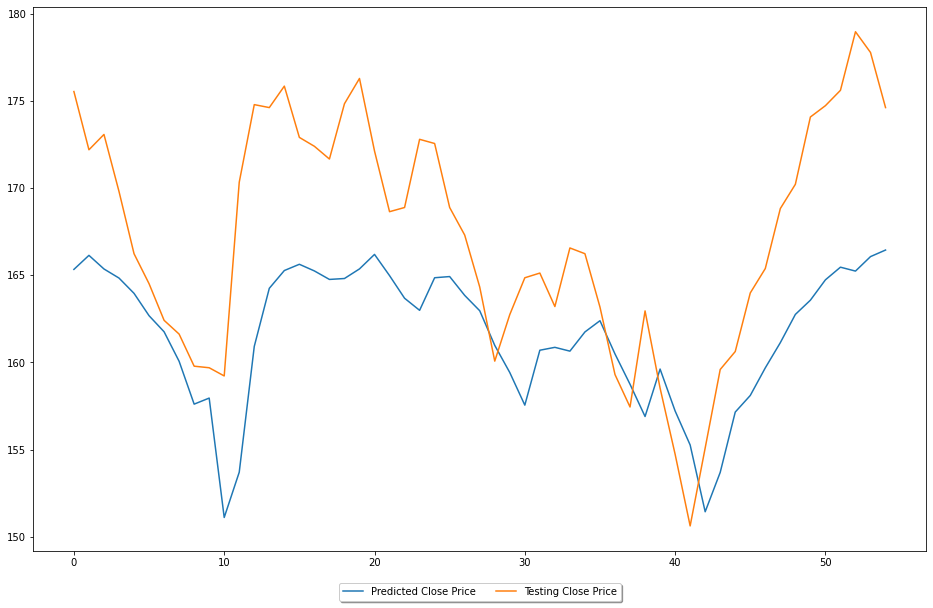

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()